# Phase Circuit to CNOT+Rz+Rx gates
We have shown in the previous notebooks how to simplify and optimize Phase Circuits.
However, the multi-qubit phase gadgets in those examples are not suitable for direct execution on most quantum devices. Therefore, they are decomposed into CNOTs and single qubit gates that are allowed by the hardware.
In the previous notebooks, we have used a naive decomposing strategy for the phase gadgets. 

However, more intrigate strategies for decomposing sequences of phase gadgets are available. These have been implemented and we will see how they perform compared to the naive strategy.

## Some administrative setup

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: /Users/griendar/Documents/Github/pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np
# import qiskit

/var/folders/3q/vjbn2sl16r1g41lg5pk752khfzf5fm/T/ipykernel_59542/3958425799.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Some utility code to display HTML elements and images/figures side-by-side:

In [3]:
from io import BytesIO
from typing import Union
from IPython.display import Image, HTML # type: ignore
def figure_to_image(fig: plt.Figure, fmt: str = "png") -> Image:
    """ Converts a Matplotlib figure to a PNG IPython Image. """
    buffer = BytesIO()
    fig.savefig(buffer, format=fmt)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    return Image(image_png, format=fmt, embed=True)
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

## PhaseCircuit decomposition to CNOTs

For our running example, we use a 3x3 grid qubit topology:

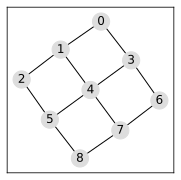

In [4]:
from pauliopt.topologies import Topology
topology = Topology.grid(3, 3)
topology.draw(figsize=(3, 3))

We construct a small random phase circuit on the same qubits:

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


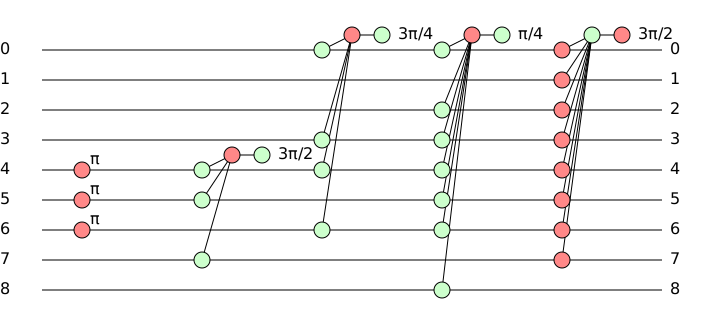

In [5]:
from pauliopt.phase import PhaseCircuit, CXCircuit
import pyzx
orig_circuit = PhaseCircuit.random(topology.num_qubits, 5, min_legs=3, rng_seed=0).simplified()
orig_circuit

In [6]:
def draw_qiskit_circuit(phasecircuit, topology, method):
    circuit = phasecircuit.to_qiskit(topology, method)
    print(circuit.count_ops())
    display(circuit.draw())
    return circuit

def circuit_to_pyzx(circuit):
    diagram = pyzx.Circuit.from_qasm(circuit.qasm())
    display(pyzx.draw(diagram))
    return diagram


We then decompose the circuit into CNOTs and single qubit rotations

Count the number of operators for each of the circuits

In [7]:
orig_circuit_naive = draw_qiskit_circuit(orig_circuit, topology, "naive")
orig_circuit_diagram = circuit_to_pyzx(orig_circuit_naive)

OrderedDict([('cx', 36), ('rx', 4), ('rz', 3)])


┌───┐┌──────────┐»
q_0: ────────────────────────────────────────────────────────┤ X ├┤ Rz(3π/4) ├»
                                                             └─┬─┘└──────────┘»
q_1: ──────────────────────────────────────────────────────────┼──────────────»
                                                               │              »
q_2: ───────────────────────────────────────────■──────────────┼──────────────»
                                                │  ┌───┐┌───┐  │              »
q_3: ───────────────────────────────────────────┼──┤ X ├┤ X ├──■──────────────»
     ┌───────┐┌───┐┌───┐┌──────────┐┌───┐┌───┐  │  └─┬─┘└─┬─┘                 »
q_4: ┤ Rx(π) ├┤ X ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──┼────■────┼───────────────────»
     ├───────┤└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘┌─┴─┐┌───┐  │                   »
q_5: ┤ Rx(π) ├──┼────■────────────────■────┼──┤ X ├┤ X ├──┼───────────────────»
     ├───────┤  │                          │  └───┘└─┬─┘  │                   »
q_6: ┤ Rx(π) ├──┼──────────────────────────┼─────────┼────■───────────────────»
     └───────┘  │                          │         │                        »
q_7: ───────────■──────────────────────────■─────────┼────────────────────────»
                                                     │                        »
q_8: ────────────────────────────────────────────────■────────────────────────»
                                                                              »
«     ┌───┐                         ┌───┐┌─────────┐┌───┐                    »
«q_0: ┤ X ├─────────────────────────┤ X ├┤ Rz(π/4) ├┤ X ├────────────────────»
«     └─┬─┘                         └─┬─┘└─────────┘└─┬─┘                    »
«q_1: ──┼─────────────────────────────┼───────────────┼──────────────────────»
«       │                             │               │                      »
«q_2: ──┼─────────────────────────────┼───────────────┼──────────────────────»
«       │  ┌───┐┌───┐     ┌───┐┌───┐  │               │  ┌───┐┌───┐          »
«q_3: ──■──┤ X ├┤ X ├─────┤ X ├┤ X ├──■───────────────■──┤ X ├┤ X ├───────■──»
«          └─┬─┘└─┬─┘┌───┐└─┬─┘└─┬─┘                     └─┬─┘└─┬─┘┌───┐  │  »
«q_4: ───────┼────■──┤ X ├──■────┼─────────────────────────┼────■──┤ X ├──┼──»
«            │       └─┬─┘       │                         │       └─┬─┘  │  »
«q_5: ───────┼─────────■─────────┼─────────────────────────┼─────────■────┼──»
«            │                   │                         │            ┌─┴─┐»
«q_6: ───────■───────────────────■─────────────────────────■────────────┤ X ├»
«                                                                       └───┘»
«q_7: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_8: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«                                        ┌──────────┐                         »
«q_0: ──■─────────────────────────────■──┤ Rx(3π/2) ├──■────■─────────────────»
«       │                           ┌─┴─┐└──────────┘┌─┴─┐  │                 »
«q_1: ──┼──────────────■─────────■──┤ X ├────────────┤ X ├──┼────■────■───────»
«       │              │       ┌─┴─┐└───┘            └───┘  │  ┌─┴─┐  │       »
«q_2: ──┼─────────■────┼────■──┤ X ├────────────────────────┼──┤ X ├──┼────■──»
«     ┌─┴─┐       │    │    │  └───┘                      ┌─┴─┐└───┘  │    │  »
«q_3: ┤ X ├───────┼────┼────┼─────────────────────────────┤ X ├──■────┼────┼──»
«     └───┘       │  ┌─┴─┐  │                             └───┘  │  ┌─┴─┐  │  »
«q_4: ───────■────┼──┤ X ├──┼────────────────────────────────────┼──┤ X ├──┼──»
«     ┌───┐  │  ┌─┴─┐└───┘┌─┴─┐                                  │  └───┘┌─┴─┐»
«q_5: ┤ X ├──┼──┤ X ├─────┤ X ├──────────────────────────────────┼───────┤ X ├»
«     └─┬─┘  │  └───┘     └───┘                                ┌─┴─┐     └───┘»


None

In [8]:
def check_equivalence(diagram):
    return orig_circuit_diagram.verify_equality(diagram)

def check_equivalence_circuit(circuit):
    return check_equivalence(circuit_to_pyzx(circuit))

orig_circuit_parity = draw_qiskit_circuit(orig_circuit, topology, "paritysynth")
check_equivalence_circuit(orig_circuit_parity)

OrderedDict([('cx', 34), ('rx', 4), ('rz', 3)])


┌───┐┌──────────┐»
q_0: ────────────────────────────────────────────────────────┤ X ├┤ Rz(3π/4) ├»
                                                             └─┬─┘└──────────┘»
q_1: ──────────────────────────────────────────────────────────┼──────────────»
                                                        ┌───┐  │              »
q_2: ───────────────────────────────────────────────────┤ X ├──┼──────────────»
                                              ┌───┐┌───┐└─┬─┘  │              »
q_3: ─────────────────────────────────────────┤ X ├┤ X ├──┼────■───────■──────»
     ┌───────┐┌───┐┌───┐┌──────────┐┌───┐┌───┐└─┬─┘└─┬─┘  │            │      »
q_4: ┤ Rx(π) ├┤ X ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──■────┼────┼────────────┼──────»
     ├───────┤└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐  │    │            │      »
q_5: ┤ Rx(π) ├──┼────■────────────────┼────■──┤ X ├──┼────■────────────┼──────»
     ├───────┤  │                     │       └─┬─┘  │               ┌─┴─┐    »
q_6: ┤ Rx(π) ├──┼─────────────────────┼─────────┼────■───────────────┤ X ├────»
     └───────┘  │                     │         │                    └───┘    »
q_7: ───────────■─────────────────────■─────────┼─────────────────────────────»
                                                │                             »
q_8: ───────────────────────────────────────────■─────────────────────────────»
                                                                              »
«     ┌───┐┌─────────┐┌───┐                                ┌───┐               »
«q_0: ┤ X ├┤ Rz(π/4) ├┤ X ├────────────────────────────────┤ X ├───────────────»
«     └─┬─┘└─────────┘└─┬─┘     ┌──────────┐     ┌───┐┌───┐└─┬─┘┌───┐┌───┐     »
«q_1: ──┼───────────────┼────■──┤ Rx(3π/2) ├─────┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──»
«       │               │    │  └──────────┘     └─┬─┘└─┬─┘     └─┬─┘└─┬─┘  │  »
«q_2: ──■───────────────┼────┼─────────────────────┼────■─────────┼────■────┼──»
«     ┌───┐             │    │              ┌───┐  │              │         │  »
«q_3: ┤ X ├─────────────■────┼───────■──────┤ X ├──┼──────────────┼─────────┼──»
«     └─┬─┘                ┌─┴─┐     │      └─┬─┘  │              │       ┌─┴─┐»
«q_4: ──■───────■───────■──┤ X ├─────┼────────┼────■──────────────■───────┤ X ├»
«               │     ┌─┴─┐└───┘     │        │                           └───┘»
«q_5: ──────────┼─────┤ X ├──────────┼────────┼────────────────────────────────»
«               │     └───┘        ┌─┴─┐      │                                »
«q_6: ──────────┼──────────────────┤ X ├──────■────────────────────────────────»
«             ┌─┴─┐                └───┘                                       »
«q_7: ────────┤ X ├────────────────────────────────────────────────────────────»
«             └───┘                                                            »
«q_8: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«                                                       
«q_0: ──────────────────────────────────────────────────
«                                                       
«q_1: ──────────────────────────────────────────────────
«               ┌───┐                                   
«q_2: ──────────┤ X ├───────────────────────────────────
«     ┌───┐     └─┬─┘                                   
«q_3: ┤ X ├───────┼─────────────────────────────────────
«     └─┬─┘       │  ┌───┐                    ┌───┐     
«q_4: ──■────■────┼──┤ X ├───────■─────────■──┤ X ├──■──
«          ┌─┴─┐  │  └─┬─┘┌───┐  │         │  └─┬─┘  │  
«q_5: ─────┤ X ├──■────┼──┤ X ├──┼─────────┼────┼────┼──
«          └───┘       │  └─┬─┘  │  ┌───┐  │    │    │  
«q_6: ─────────────────┼────┼────┼──┤ X ├──┼────┼────┼──
«                      │    │  ┌─┴─┐└─┬─┘┌─┴─┐  │  ┌─┴─┐
«q_7: ─────────────────■────┼──┤ X ├──■──┤ X ├──■──┤ X ├
«                           │  └───┘     └───┘     └───┘
«q_8: ──────────────────────■────

None

True

# Using this decomposition method together with the annealing optimization

In [9]:
from pauliopt.phase import OptimizedPhaseCircuit
from math import log10, ceil
def log_iter(it, prev_cost, new_cost, accepted, flip, t, num_iters):
    if new_cost < prev_cost:
        print(f"Iter #{it:>0{ceil(log10(num_iters-1))}}, new cost: {new_cost}")
loggers = {
    "log_start": lambda cost, num_iters: print(f"Init cost: {cost}"),
    "log_iter": log_iter,
    "log_end": lambda cost, num_iters: print(f"Final cost: {cost}"),
}

In [10]:
def opt_to_qiskit(opt, method):
    qiskit_circuit = opt.to_qiskit(method)
    display(qiskit_circuit.draw())
    print(qiskit_circuit.count_ops())
    print("cx" in qiskit_circuit.count_ops())
    print(check_equivalence_circuit(qiskit_circuit))
    
def run_annealer(circuit, cx_block, method):
    opt = OptimizedPhaseCircuit(orig_circuit, topology, cx_block=cx_block, rng_seed=0, method=method)
    opt.anneal(1000, schedule=("geometric", 1, 1e-5), loggers=loggers, method=method)

    display(opt.phase_block.to_svg(scale=0.8))
    display(opt.cx_block.draw(figsize=(3, 3)))
    opt_to_qiskit(opt, method)
    return opt

Init cost: 36
Iter #003, new cost: 38
Iter #006, new cost: 36
Iter #023, new cost: 44
Iter #100, new cost: 44
Iter #139, new cost: 40
Iter #240, new cost: 38
Iter #241, new cost: 32
Iter #576, new cost: 30
Final cost: 30


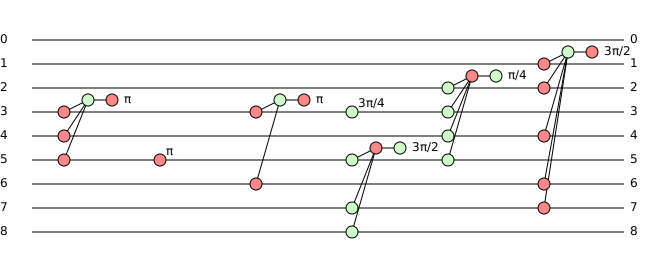

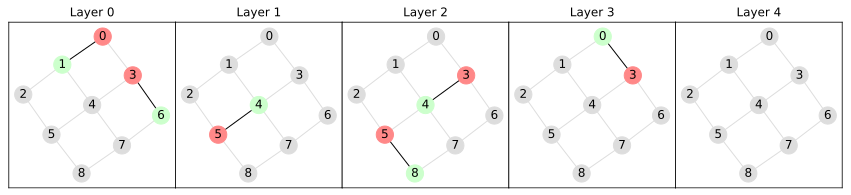

None

┌───┐                                                          »
q_0: ──■──┤ X ├──────────────────────────────────────────────────────────»
       │  └─┬─┘                                                          »
q_1: ──┼────■────────────────────────────────────────────────────────────»
       │                                                                 »
q_2: ──┼─────────────────────────────────────────────────────────────────»
     ┌─┴─┐┌───┐     ┌───┐          ┌───────┐               ┌───────┐     »
q_3: ┤ X ├┤ X ├─────┤ X ├───────■──┤ Rx(π) ├──■─────────■──┤ Rx(π) ├──■──»
     └───┘└─┬─┘     └─┬─┘     ┌─┴─┐└───────┘┌─┴─┐       │  └───────┘  │  »
q_4: ───────■────■────┼────■──┤ X ├─────────┤ X ├──■────┼─────────────┼──»
     ┌───┐     ┌─┴─┐  │  ┌─┴─┐└───┘         └───┘┌─┴─┐  │  ┌───────┐  │  »
q_5: ┤ X ├─────┤ X ├──┼──┤ X ├───────────────────┤ X ├──┼──┤ Rx(π) ├──┼──»
     └─┬─┘     └───┘  │  └───┘                   └───┘┌─┴─┐└───────┘┌─┴─┐»
q_6: ──┼──────────────■───────────────────────────────┤ X ├─────────┤ X ├»
       │                                              └───┘         └───┘»
q_7: ──┼────■────────────────────────────────────────────────────────────»
       │  ┌─┴─┐                                                          »
q_8: ──■──┤ X ├──────────────────────────────────────────────────────────»
          └───┘                                                          »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                       ┌───┐┌─────────┐┌───┐               »
«q_2: ──────────────────────────────────┤ X ├┤ Rz(π/4) ├┤ X ├───────────────»
«     ┌──────────┐                      └─┬─┘└─────────┘└─┬─┘               »
«q_3: ┤ Rz(3π/4) ├─────■──────────────────┼───────────────┼─────────■───────»
«     └──────────┘   ┌─┴─┐                │               │       ┌─┴─┐     »
«q_4: ───────────────┤ X ├───────────■────┼───────────────┼────■──┤ X ├──■──»
«        ┌───┐    ┌──┴───┴───┐┌───┐┌─┴─┐  │               │  ┌─┴─┐└───┘  │  »
«q_5: ───┤ X ├────┤ Rz(3π/2) ├┤ X ├┤ X ├──■───────────────■──┤ X ├───────┼──»
«        └─┬─┘    └──────────┘└─┬─┘└───┘┌───┐                └───┘       │  »
«q_6: ─────┼────────────────────┼───────┤ X ├────────────────────────────┼──»
«          │                    │       └─┬─┘                          ┌─┴─┐»
«q_7: ─────┼────────────────────┼────■────■────────────────────────────┤ X ├»
«          │                    │  ┌─┴─┐                               └───┘»
«q_8: ─────■────────────────────■──┤ X ├────────────────────────────────────»
«                                  └───┘                                    »
«                                     ┌───┐                    
«q_0: ────────────────────────────────┤ X ├─────────────────■──
«               ┌──────────┐          └─┬─┘                 │  
«q_1: ──■────■──┤ Rx(3π/2) ├──■────■────■───────────────────┼──
«       │  ┌─┴─┐└──────────┘┌─┴─┐  │                        │  
«q_2: ──┼──┤ X ├────────────┤ X ├──┼────────────────────────┼──
«       │  └───┘            └───┘  │            ┌───┐┌───┐┌─┴─┐
«q_3: ──┼──────────────────────────┼────────────┤ X ├┤ X ├┤ X ├
«     ┌─┴─┐                      ┌─┴─┐          └─┬─┘└─┬─┘└───┘
«q_4: ┤ X ├──────────────────────┤ X ├──■────■────┼────■───────
«     └───┘                      └───┘  │  ┌─┴─┐  │  ┌───┐     
«q_5: ──────────────────────────────────┼──┤ X ├──┼──┤ X ├─────
«                                       │  ├───┤  │  └─┬─┘     
«q_6: ──────────────────────────────────┼──┤ X ├──■────┼───────
«                                     ┌─┴─┐└─┬─┘       │       
«q_7: ────────────────────────────────┤ X ├──■─────────┼───────
«                                     └───┘            │       
«q_8: ─────────

OrderedDict([('cx', 36), ('rx', 4), ('rz', 3)])
True


None

True


In [11]:
opt_naive = run_annealer(orig_circuit, 5, "naive")

Init cost: 34
Iter #002, new cost: 30
Iter #009, new cost: 32
Iter #141, new cost: 32
Iter #165, new cost: 31
Iter #169, new cost: 30
Iter #972, new cost: 28
Final cost: 28


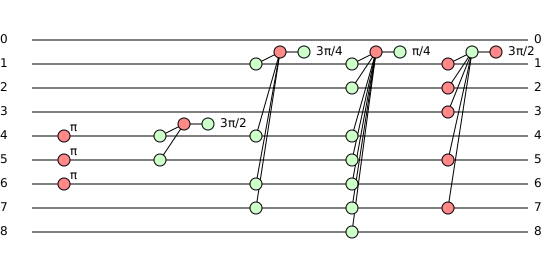

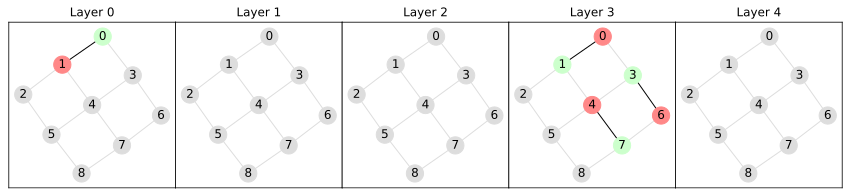

None

┌───┐                                                               »
q_0: ┤ X ├──■────────────────────────────────────────────────────────────»
     └─┬─┘┌─┴─┐                                    ┌───┐┌──────────┐┌───┐»
q_1: ──■──┤ X ├────────────────────────────────────┤ X ├┤ Rz(3π/4) ├┤ X ├»
          └───┘                                    └─┬─┘└──┬───┬───┘└─┬─┘»
q_2: ────────────────────────────────────────────────┼─────┤ X ├──────■──»
                                                     │     └─┬─┘         »
q_3: ───────■────────────────────────────────────────┼───────┼───────────»
     ┌───┐  │  ┌───────┐┌───┐┌──────────┐┌───┐┌───┐  │       │           »
q_4: ┤ X ├──┼──┤ Rx(π) ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──■───────┼────────■──»
     └─┬─┘  │  ├───────┤└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐     │        │  »
q_5: ──┼────┼──┤ Rx(π) ├──■────────────────┼────■──┤ X ├─────■────────┼──»
       │  ┌─┴─┐├───────┤                   │       └─┬─┘              │  »
q_6: ──┼──┤ X ├┤ Rx(π) ├──■────────────────┼─────────┼────────────────┼──»
       │  └───┘└───────┘┌─┴─┐              │         │              ┌─┴─┐»
q_7: ──■────────────────┤ X ├──────────────■─────────┼──────────────┤ X ├»
                        └───┘                        │              └───┘»
q_8: ────────────────────────────────────────────────■───────────────────»
                                                                         »
«                                                     ┌───┐                    »
«q_0: ─────────────────────────────────────────────■──┤ X ├────────────────────»
«     ┌─────────┐                      ┌───┐┌───┐┌─┴─┐└─┬─┘                    »
«q_1: ┤ Rz(π/4) ├──────────────────────┤ X ├┤ X ├┤ X ├──■──────────────────────»
«     └─────────┘                      └─┬─┘└─┬─┘├───┤                         »
«q_2: ───────────────────────────────────┼────■──┤ X ├─────────────────────────»
«                     ┌──────────┐       │       └─┬─┘                         »
«q_3: ─────────────■──┤ Rx(3π/2) ├──■────┼─────────┼───────────────────────────»
«                ┌─┴─┐└──────────┘┌─┴─┐  │         │       ┌───┐          ┌───┐»
«q_4: ─────■─────┤ X ├────────────┤ X ├──■────■────┼────■──┤ X ├──────────┤ X ├»
«        ┌─┴─┐   └───┘            └───┘     ┌─┴─┐  │    │  └─┬─┘┌───┐     └─┬─┘»
«q_5: ───┤ X ├──────────────────────────────┤ X ├──■────┼────┼──┤ X ├───────┼──»
«        └───┘                              └───┘       │    │  └─┬─┘       │  »
«q_6: ──────────────────────────────────────────────────┼────┼────┼────■────┼──»
«                                                     ┌─┴─┐  │    │  ┌─┴─┐  │  »
«q_7: ────────────────────────────────────────────────┤ X ├──■────┼──┤ X ├──■──»
«                                                     └───┘       │  └───┘     »
«q_8: ────────────────────────────────────────────────────────────■────────────»
«                                                                              »
«          
«q_0: ─────
«          
«q_1: ─────
«          
«q_2: ─────
«          
«q_3: ──■──
«       │  
«q_4: ──┼──
«       │  
«q_5: ──┼──
«     ┌─┴─┐
«q_6: ┤ X ├
«     └───┘
«q_7: ─────
«          
«q_8: ─────
«

OrderedDict([('cx', 28), ('rx', 4), ('rz', 3)])
True


None

True


In [12]:
opt_parity = run_annealer(orig_circuit, 5, "paritysynth")

In [13]:
opt_to_qiskit(opt_naive, "paritysynth")

┌───┐                                                                »
q_0: ──■──┤ X ├────────────────────────────────────────────────────────────────»
       │  └─┬─┘                                                                »
q_1: ──┼────■──────────────────────────────────────────────────────────────────»
       │                                                                       »
q_2: ──┼───────────────────────────────────────────────────────────────────────»
     ┌─┴─┐┌───┐     ┌───┐              ┌───────┐          ┌───────┐┌──────────┐»
q_3: ┤ X ├┤ X ├─────┤ X ├───────────■──┤ Rx(π) ├──■────■──┤ Rx(π) ├┤ Rz(3π/4) ├»
     └───┘└─┬─┘     └─┬─┘           │  └───────┘  │  ┌─┴─┐└─┬───┬─┘└──┬───┬───┘»
q_4: ───────■────■────┼─────────────┼──────■──────┼──┤ X ├──┤ X ├─────┤ X ├────»
     ┌───┐     ┌─┴─┐  │  ┌───────┐  │    ┌─┴─┐    │  ├───┤  └─┬─┘     └─┬─┘    »
q_5: ┤ X ├─────┤ X ├──┼──┤ Rx(π) ├──┼────┤ X ├────┼──┤ X ├────┼─────────■──────»
     └─┬─┘     └───┘  │  └───────┘┌─┴─┐  └───┘  ┌─┴─┐└─┬─┘    │                »
q_6: ──┼──────────────■───────────┤ X ├─────────┤ X ├──┼──────┼─────────■──────»
       │                          └───┘         └───┘  │      │       ┌─┴─┐    »
q_7: ──┼───────────────────────────────────────────────┼──────■───────┤ X ├────»
       │                                               │              └───┘    »
q_8: ──■───────────────────────────────────────────────■───────────────────────»
                                                                               »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                               ┌──────────┐»
«q_1: ──────────────────────────────────────────────────■────■──┤ Rx(3π/2) ├»
«                                     ┌───┐┌─────────┐  │    │  └──────────┘»
«q_2: ────────────────────────────────┤ X ├┤ Rz(π/4) ├──┼────┼──────────────»
«     ┌───┐┌──────────┐               └─┬─┘└─────────┘  │  ┌─┴─┐            »
«q_3: ┤ X ├┤ Rz(3π/2) ├──■─────────■────┼───────────────┼──┤ X ├────────────»
«     └─┬─┘└──────────┘┌─┴─┐       │    │               │  └───┘            »
«q_4: ──■──────────────┤ X ├──■────┼────┼───────────────┼───────────────────»
«     ┌───┐            └───┘┌─┴─┐  │    │             ┌─┴─┐                 »
«q_5: ┤ X ├─────────────────┤ X ├──┼────■─────────────┤ X ├─────────────────»
«     └─┬─┘                 └───┘┌─┴─┐                └───┘                 »
«q_6: ──┼────────────────────────┤ X ├──■───────────────────────────────────»
«       │                        └───┘┌─┴─┐                                 »
«q_7: ──┼─────────────────────────────┤ X ├─────────────────────────────────»
«       │                             └───┘                                 »
«q_8: ──■───────────────────────────────────────────────────────────────────»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──■───────────────────────────────────────────────────────────────────»
«     ┌─┴─┐┌───┐                                                            »
«q_2: ┤ X ├┤ X ├────────────────────────────────────────────────────────────»
«     └───┘└─┬─┘                         ┌───┐          ┌───┐               »
«q_3: ───────┼────────────────────────■──┤ X ├───────■──┤ X ├──■────────────»
«            │                 ┌───┐  │  └─┬─┘┌───┐┌─┴─┐└─┬─┘┌─┴─┐          »
«q_4: ───────┼─────────────────┤ X ├──┼────■──┤ X ├┤ X ├──■──┤ X ├──■───────»
«            │            ┌───┐└─┬─┘  │       └─┬─┘└───┘     └───┘  │       »
«q_5: ───────■────■───────┤ X ├──■────┼─────────■───────────────────┼───────»
«                 │       └─┬─┘     ┌─┴─┐            

OrderedDict([('cx', 77), ('rx', 4), ('rz', 3)])
True


None

True


In [14]:
opt_to_qiskit(opt_parity, "naive")

┌───┐                                                                    »
q_0: ┤ X ├──■─────────────────────────────────────────────────────────────────»
     └─┬─┘┌─┴─┐                                    ┌───┐┌──────────┐┌───┐     »
q_1: ──■──┤ X ├────────────────────────────────────┤ X ├┤ Rz(3π/4) ├┤ X ├─────»
          └───┘                                    └─┬─┘└──┬───┬───┘└─┬─┘     »
q_2: ────────────────────────────────────────────────┼─────┤ X ├──────┼───────»
                                                     │     └─┬─┘      │       »
q_3: ───────■────────────────────────────────────────┼───────┼────────┼───────»
     ┌───┐  │  ┌───────┐┌───┐┌──────────┐┌───┐┌───┐  │       │        │  ┌───┐»
q_4: ┤ X ├──┼──┤ Rx(π) ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──■───────┼────────■──┤ X ├»
     └─┬─┘  │  ├───────┤└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐     │           └─┬─┘»
q_5: ──┼────┼──┤ Rx(π) ├──■────────────────■────┼──┤ X ├─────■─────────────┼──»
       │  ┌─┴─┐├───────┤                        │  └─┬─┘                   │  »
q_6: ──┼──┤ X ├┤ Rx(π) ├──■─────────────────────┼────┼─────────────────────┼──»
       │  └───┘└───────┘┌─┴─┐                   │    │                     │  »
q_7: ──■────────────────┤ X ├───────────────────■────┼─────────────────────■──»
                        └───┘                        │                        »
q_8: ────────────────────────────────────────────────■────────────────────────»
                                                                              »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«                    ┌───┐┌───┐┌─────────┐┌───┐┌───┐                         »
«q_1: ───────────────┤ X ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ X ├───────■──────────────■──»
«                    └─┬─┘└─┬─┘└─────────┘└─┬─┘└─┬─┘┌───┐  │            ┌─┴─┐»
«q_2: ─────────────────┼────■───────────────■────┼──┤ X ├──┼─────────■──┤ X ├»
«                      │                         │  └─┬─┘┌─┴─┐       │  └───┘»
«q_3: ─────────────────┼─────────────────────────┼────┼──┤ X ├───────┼───────»
«               ┌───┐  │                         │    │  ├───┤       │       »
«q_4: ──────────┤ X ├──■─────────────────────────■────┼──┤ X ├───────┼───────»
«               └─┬─┘                                 │  └─┬─┘┌───┐┌─┴─┐     »
«q_5: ────────────┼───────────────────────────────────■────┼──┤ X ├┤ X ├─────»
«                 │                                        │  └─┬─┘└───┘     »
«q_6: ──■────■────┼────────────────────────────────────────┼────┼────■───────»
«     ┌─┴─┐┌─┴─┐  │                                        │    │  ┌─┴─┐     »
«q_7: ┤ X ├┤ X ├──■────────────────────────────────────────■────┼──┤ X ├─────»
«     └───┘└───┘                                                │  └───┘     »
«q_8: ──────────────────────────────────────────────────────────■────────────»
«                                                                            »
«                                          ┌───┐
«q_0: ──────────────────────────────────■──┤ X ├
«          ┌──────────┐               ┌─┴─┐└─┬─┘
«q_1: ──■──┤ Rx(3π/2) ├──■────■────■──┤ X ├──■──
«       │  └──────────┘  │  ┌─┴─┐  │  └───┘     
«q_2: ──┼────────────────┼──┤ X ├──┼────■───────
«       │                │  └───┘┌─┴─┐  │       
«q_3: ──┼────────────────┼───────┤ X ├──┼────■──
«       │                │  ┌───┐└───┘  │    │  
«q_4: ──┼────────────────┼──┤ X ├───────┼────┼──
«       │                │  └─┬─┘     ┌─┴─┐  │  
«q_5: ──┼────────────────┼────┼───────┤ X ├──┼──
«       │                │    │       └───┘┌─┴─┐
«q_6: ──┼────────────────┼────┼────────────┤ X ├
«     ┌─┴─┐            ┌─┴─┐  │            └───┘
«q_7: ┤ X ├────────────┤ X ├──■─────────────────
«     └───┘            └───┘                    
«q_8: ──────────────────────────────────────────
«

OrderedDict([('cx', 36), ('rx', 4), ('rz', 3)])
True


None

True


# Experiments
We now generate many random phase circuits and compile them in different ways to the same architecture and count their respective CNOT costs.

In [15]:
from qiskit import transpile

def compile_with_qiskit(circuit, topology):
     return transpile(circuit, 
                      optimization_level=3, 
                      basis_gates=['u1', 'u2', 'u3', 'cx'], 
                      coupling_map=[[v for v in c] for c in topology._couplings])
    

In [23]:
def count_cnots(circuit):
    ops = circuit.count_ops()
    if "cx" in ops:
        return ops["cx"]
    return 0

def generate_and_compile(n_gadgets, topology, cx_block=5, n_iter=100):
    data = {}
    circuit = PhaseCircuit.random(topology.num_qubits, n_gadgets, min_legs=3).simplified()
    qiskit_circuit = circuit.to_qiskit(topology, "naive")
    data["original"] = count_cnots(qiskit_circuit)
    data["qiskit"] = count_cnots(compile_with_qiskit(qiskit_circuit, topology))
    data["parity"] = count_cnots(circuit.to_qiskit(topology, "paritysynth"))
    opt1 =  OptimizedPhaseCircuit(circuit, topology, cx_block=cx_block, method="naive")
    opt2 = OptimizedPhaseCircuit(circuit, topology, cx_block=cx_block, method="paritysynth")
    opt1.anneal(n_iter, schedule=("geometric", 1, 1e-5), method="naive")
    opt2.anneal(n_iter, schedule=("geometric", 1, 1e-5), method="paritysynth")
    data["annealer"] = count_cnots(opt1.to_qiskit("naive"))
    data["annealer+parity"] = count_cnots(opt2.to_qiskit("paritysynth"))
    return data

In [17]:
import pandas as pd

In [35]:
n = 100
print("Results for", n, "randomly generated phase circuits")
gadgets = [1,2,5,10,50,100]#,1000]
results = []
for n_gadgets in gadgets:
    print(n_gadgets)
    for _ in range(n):
        data = generate_and_compile(n_gadgets, topology)
        data["n_gadgets"] = n_gadgets
        results.append(data)
df = pd.DataFrame(results)
df.to_csv("preliminary results.csv")
df.groupby(["n_gadgets"]).mean()

Results for 100 randomly generated phase circuits
1
2
5
10
50
100


,original,qiskit,parity,annealer,annealer+parity
n_gadgets,,,,,
1,9.10,8.76,13.01,11.04,10.80
2,16.80,16.60,22.06,19.56,17.75
5,41.22,44.77,56.37,43.24,40.86
10,84.62,93.53,86.54,80.28,70.50
50,401.32,485.34,208.11,333.24,192.38
100,793.70,939.93,341.73,608.58,319.43


In [36]:
df.groupby(["n_gadgets"]).agg(["mean", "min", "max", "std"])

original                       qiskit                        parity  \
              mean  min  max        std    mean  min   max        std    mean   
n_gadgets                                                                       
1             9.10    0   16   4.768372    8.76    0    16   4.710015   13.01   
2            16.80    0   32   7.003607   16.60    0    32   7.110953   22.06   
5            41.22    4   70  10.805517   44.77    3    76  13.264866   56.37   
10           84.62   46  122  16.408165   93.53   49   134  18.294700   86.54   
50          401.32  310  476  34.730966  485.34  390   629  46.042848  208.11   
100         793.70  662  924  55.532227  939.93  771  1087  59.930474  341.73   

                               annealer                      annealer+parity  \
           min  max        std     mean  min  max        std            mean   
n_gadgets                                                                      
1            0   48   9.203090    11.04    0   18   4.622999           10.80   
2            0   57  11.049768    19.56    0   30   5.352843           17.75   
5           12  102  17.380272    43.24   16   60   7.530571           40.86   
10          42  116  14.486092    80.28   46  114  11.989962           70.50   
50         172  236  15.878895   333.24  260  416  28.104825          192.38   
100        284  394  19.970106   608.58  506  704  39.992216          319.43   

                                
           min  max        std  
n_gadgets                       
1            0   18   4.696872  
2            0   30   5.920986  
5           12   64  10.328953  
10          42   94  11.584124  
50         167  220  12.676854  
100        271  362  14.727323

In [39]:
df2 = pd.DataFrame()
df2["n_gadgets"] = df["n_gadgets"]
df2["qiskit"] = (df["qiskit"]/df["original"]*100)-100
df2["parity"] = (df["parity"]/df["original"]*100)-100
df2["annealer"] = (df["annealer"]/df["original"]*100)-100
df2["annealer+parity"] = (df["annealer+parity"]/df["original"]*100)-100

In [40]:
df2.groupby(["n_gadgets"]).agg(["mean", "min", "max", "std"])

qiskit                                      parity             \
                mean        min        max        std       mean        min   
n_gadgets                                                                     
1          -4.306447 -25.000000   0.000000   6.271916  63.220974   0.000000   
2          -1.584882 -35.714286  33.333333  11.980329  41.885042 -42.857143   
5           8.448170 -27.777778  52.173913  16.591096  42.600148 -52.500000   
10         11.731940 -33.000000  57.407407  16.145102   5.436692 -32.727273   
50         21.377875  -3.504673  49.740933  11.441168 -47.867309 -59.433962   
100        18.684447  -0.129534  38.904494   7.151893 -56.812251 -62.672811   

                                    annealer                         \
                  max         std       mean        min         max   
n_gadgets                                                             
1          666.666667  119.559059        NaN   0.000000         inf   
2          475.000000   74.908916        NaN -28.571429         inf   
5          227.777778   46.257840  13.000110 -44.444444  300.000000   
10         110.416667   25.348127  -2.448704 -41.379310   65.384615   
50         -33.918129    4.991075 -16.627144 -31.081081   -1.796407   
100        -48.521505    2.978363 -23.103368 -38.926174   -9.090909   

                     annealer+parity                                    
                 std            mean        min         max        std  
n_gadgets                                                               
1                NaN             NaN -50.000000         inf        NaN  
2                NaN       14.525224 -42.857143  133.333333  36.458159  
5          40.914450        5.037263 -52.500000  200.000000  35.308592  
10         18.967638      -14.185473 -50.909091   55.555556  19.000682  
50          7.309515      -51.843807 -59.433962  -40.718563   3.762367  
100         5.480264      -59.622966 -65.283843  -52.593660   2.489793